<a href="https://colab.research.google.com/github/devisriyavarshini/Image-Clustering/blob/main/CLIP%2BLit(cifar10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
!pip install ftfy regex tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade --force-reinstall torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 21.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
import pytorch_lightning as pl
import numpy as np
import os


In [ ]:
# ------------------ 1. Load CIFAR-10 Dataset ------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

labels = train_dataset.classes  # CIFAR-10 class labels


100%|██████████| 170M/170M [00:03<00:00, 55.0MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
#----------Exploratory Data Analysis-----------

# Image Statistics
print(f"Training Set Shape: {train_dataset.data.shape}")
print(f"Test Set Shape: {test_dataset.data.shape}")
print(f"Image Size: {train_dataset.data[0].shape}")
print(f"Data Type: {train_dataset.data.dtype}")
print(f"Minimum Pixel Value: {train_dataset.data.min()}")
print(f"Maximum Pixel Value: {train_dataset.data.max()}")
print(f"Mean Pixel Value: {train_dataset.data.mean()}")
print(f"Standard Deviation Pixel Value: {train_dataset.data.std()}")

Training Set Shape: (50000, 32, 32, 3)
Test Set Shape: (10000, 32, 32, 3)
Image Size: (32, 32, 3)
Data Type: uint8
Minimum Pixel Value: 0
Maximum Pixel Value: 255
Mean Pixel Value: 120.70756512369792
Standard Deviation Pixel Value: 64.1500758911213


In [ ]:
# Class Size and Distribution
classes, counts = np.unique(train_dataset.targets, return_counts=True)
num_classes = len(classes)
print(f"\nNumber of Classes: {num_classes}")
for cls, count in zip(classes, counts):
    print(f"Class {train_dataset.classes[cls]}: {count} images")


Number of Classes: 10
Class airplane: 5000 images
Class automobile: 5000 images
Class bird: 5000 images
Class cat: 5000 images
Class deer: 5000 images
Class dog: 5000 images
Class frog: 5000 images
Class horse: 5000 images
Class ship: 5000 images
Class truck: 5000 images


In [ ]:
# Image Size and Channels
image_shape = train_dataset.data[0].shape
print(f"\nImage Size: {image_shape[0]} x {image_shape[1]}")
print(f"Number of Channels: {image_shape[2]}")



Image Size: 32 x 32
Number of Channels: 3


In [ ]:
# Check for Class Imbalance
class_ratios = counts / np.sum(counts)
print(f"\nClass Ratios: {class_ratios}")
if np.any(np.abs(class_ratios - 1/num_classes) > 0.05):
    print("Possible class imbalance detected.")
else:
    print("Classes are relatively balanced.")


Class Ratios: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Classes are relatively balanced.


In [ ]:
# Labels for Each Image
print(f"\nLabels for first 10 images: {train_dataset.targets[:10]}")
print(f"Corresponding class names: {[train_dataset.classes[label] for label in train_dataset.targets[:10]]}")


Labels for first 10 images: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3]
Corresponding class names: ['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship', 'cat']


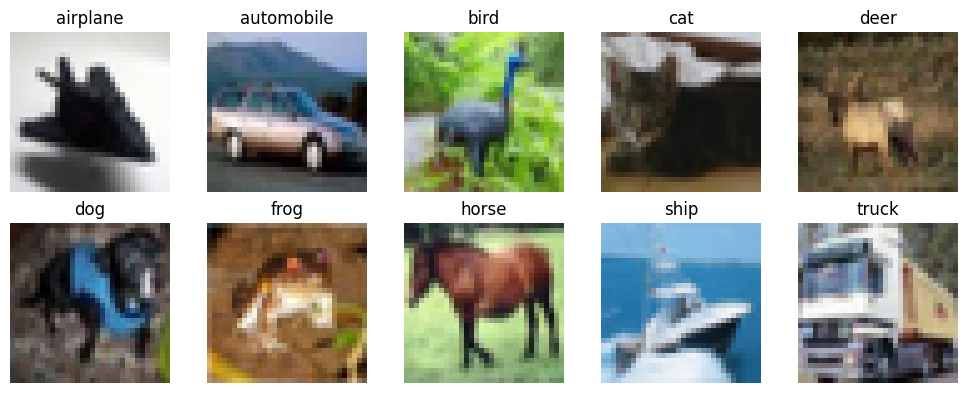

In [ ]:
import matplotlib.pyplot as plt
# Display some sample images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()
for i in range(10):
    idx = np.where(np.array(train_dataset.targets) == i)[0][0]
    axes[i].imshow(train_dataset.data[idx])
    axes[i].set_title(train_dataset.classes[i])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

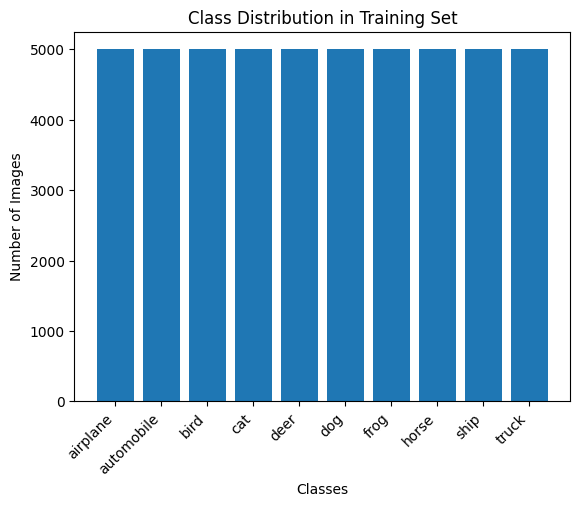

In [ ]:
# Class Distribution
class_counts = np.unique(train_dataset.targets, return_counts=True)
plt.bar(class_counts[0], class_counts[1])
plt.xticks(class_counts[0], train_dataset.classes, rotation=45, ha='right')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.show()


In [ ]:
# ------------------ 2. Tokenization using CLIP ------------------
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

text_inputs = processor(text=labels, return_tensors="pt", padding=True)

with torch.no_grad():
    text_features = clip_model.get_text_features(**text_inputs)

text_embeddings = text_features.cpu().numpy()  # Not used in training here, but ready for downstream tasks


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:

# ------------------ 3. PyTorch Lightning Model ------------------
class FineTuneModel(pl.LightningModule):
    def __init__(self, num_classes=10):
        super(FineTuneModel, self).__init__()
        self.save_hyperparameters()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def forward(self, x):
        return self.model(x)

    def extract_features(self, x):
      # Extract features before the final classification layer
      for name, module in self.model._modules.items():
        x = module(x)
        if name == "10":  # Linear(512, num_classes) is at index 11
            break
      return x

    def training_step(self, batch, batch_idx):
      x, y = batch
      logits = self(x)
      loss = self.criterion(logits, y)
      acc = (logits.argmax(dim=1) == y).float().mean()

      self.train_losses.append(loss.item())
      self.train_accuracies.append(acc.item())

      self.log("train_loss", loss, prog_bar=True)
      self.log("train_acc", acc, prog_bar=True)

      return loss


    def validation_step(self, batch, batch_idx):
      x, y = batch
      logits = self(x)
      loss = self.criterion(logits, y)
      acc = (logits.argmax(dim=1) == y).float().mean()

      self.val_losses.append(loss.item())
      self.val_accuracies.append(acc.item())

      self.log("val_loss", loss, prog_bar=True)  # ✅ Required for early stopping
      self.log("val_acc", acc, prog_bar=True)


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


In [ ]:


# ------------------ 4. Train Model with EarlyStopping ------------------
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

device = "cuda" if torch.cuda.is_available() else "cpu"

early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)

model = FineTuneModel()

trainer = pl.Trainer(
    max_epochs=20,
    accelerator=device,
    log_every_n_steps=10,
    callbacks=[early_stop, checkpoint]
)

trainer.fit(model, train_loader, test_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 8.8 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.064    Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


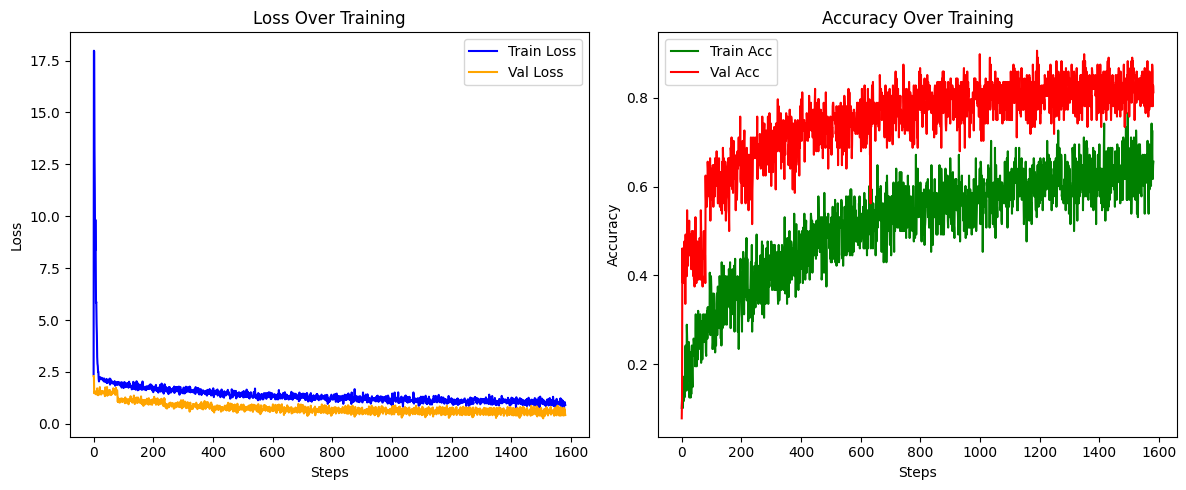

In [ ]:
# ------------------ 5. Plot Accuracy and Loss ------------------
import matplotlib.pyplot as plt
def plot_metrics(model):
    # Use the shorter length for steps
    steps = list(range(min(len(model.train_losses), len(model.val_losses))))  # Changed line
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(steps, model.train_losses[:len(steps)], label='Train Loss', color='blue')  # Changed line
    plt.plot(steps, model.val_losses[:len(steps)], label='Val Loss', color='orange')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Loss Over Training')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(steps, model.train_accuracies[:len(steps)], label='Train Acc', color='green')  # Changed line
    plt.plot(steps, model.val_accuracies[:len(steps)], label='Val Acc', color='red')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Training')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(model)


Test Accuracy: 82.12%
              precision    recall  f1-score   support

    airplane       0.85      0.86      0.85      1000
  automobile       0.92      0.89      0.91      1000
        bird       0.73      0.74      0.73      1000
         cat       0.66      0.62      0.64      1000
        deer       0.81      0.80      0.80      1000
         dog       0.76      0.71      0.73      1000
        frog       0.87      0.88      0.87      1000
       horse       0.84      0.88      0.86      1000
        ship       0.90      0.92      0.91      1000
       truck       0.87      0.91      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000


Confusion Matrix:


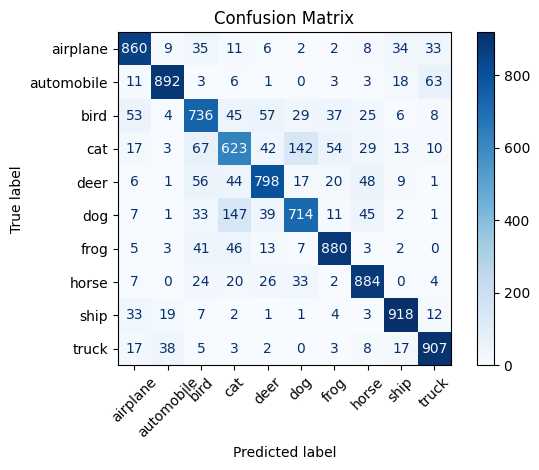

In [ ]:
# ------------------ 6. Evaluate on Test Set ------------------
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
def evaluate_model(model, test_loader, device="cuda"):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\nTest Accuracy: {100 * correct / total:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

evaluate_model(model, test_loader, device=device)

📦 Extracting features...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


📉 Running t-SNE...
🎨 Plotting...


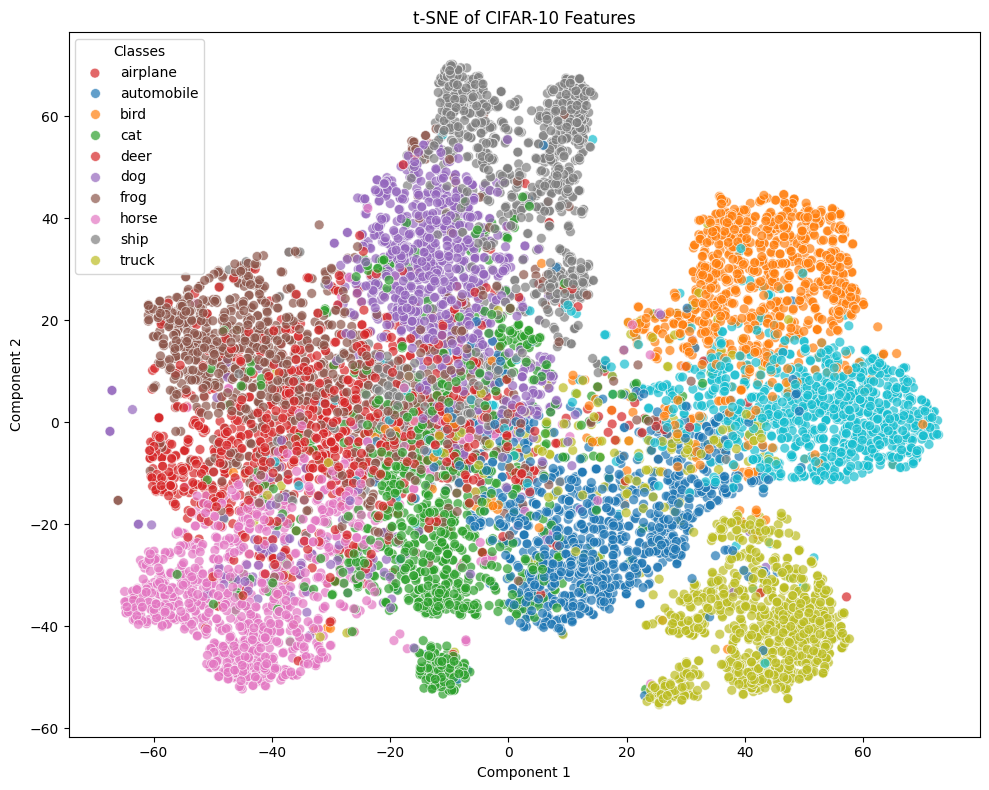

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

def extract_features(model, dataloader, device):
    model.to(device)
    model.eval()

    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)

            # Forward pass through all layers except the last Linear
            x = imgs
            for layer in list(model.model.children())[:-1]:
                x = layer(x)

            features.append(x.cpu().numpy())
            labels.extend(lbls.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.array(labels)
    return features, labels

def plot_tsne(model, dataloader, device="cuda"):
    print("Extracting features...")
    features, labels = extract_features(model, dataloader, device)

    print("Running t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features)

    print("Plotting...")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels, palette="tab10", s=50, alpha=0.7, legend="full")
    plt.title("t-SNE of CIFAR-10 Features")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Classes", loc="best", labels=train_dataset.classes)
    plt.tight_layout()
    plt.show()

plot_tsne(model, test_loader, device=device)


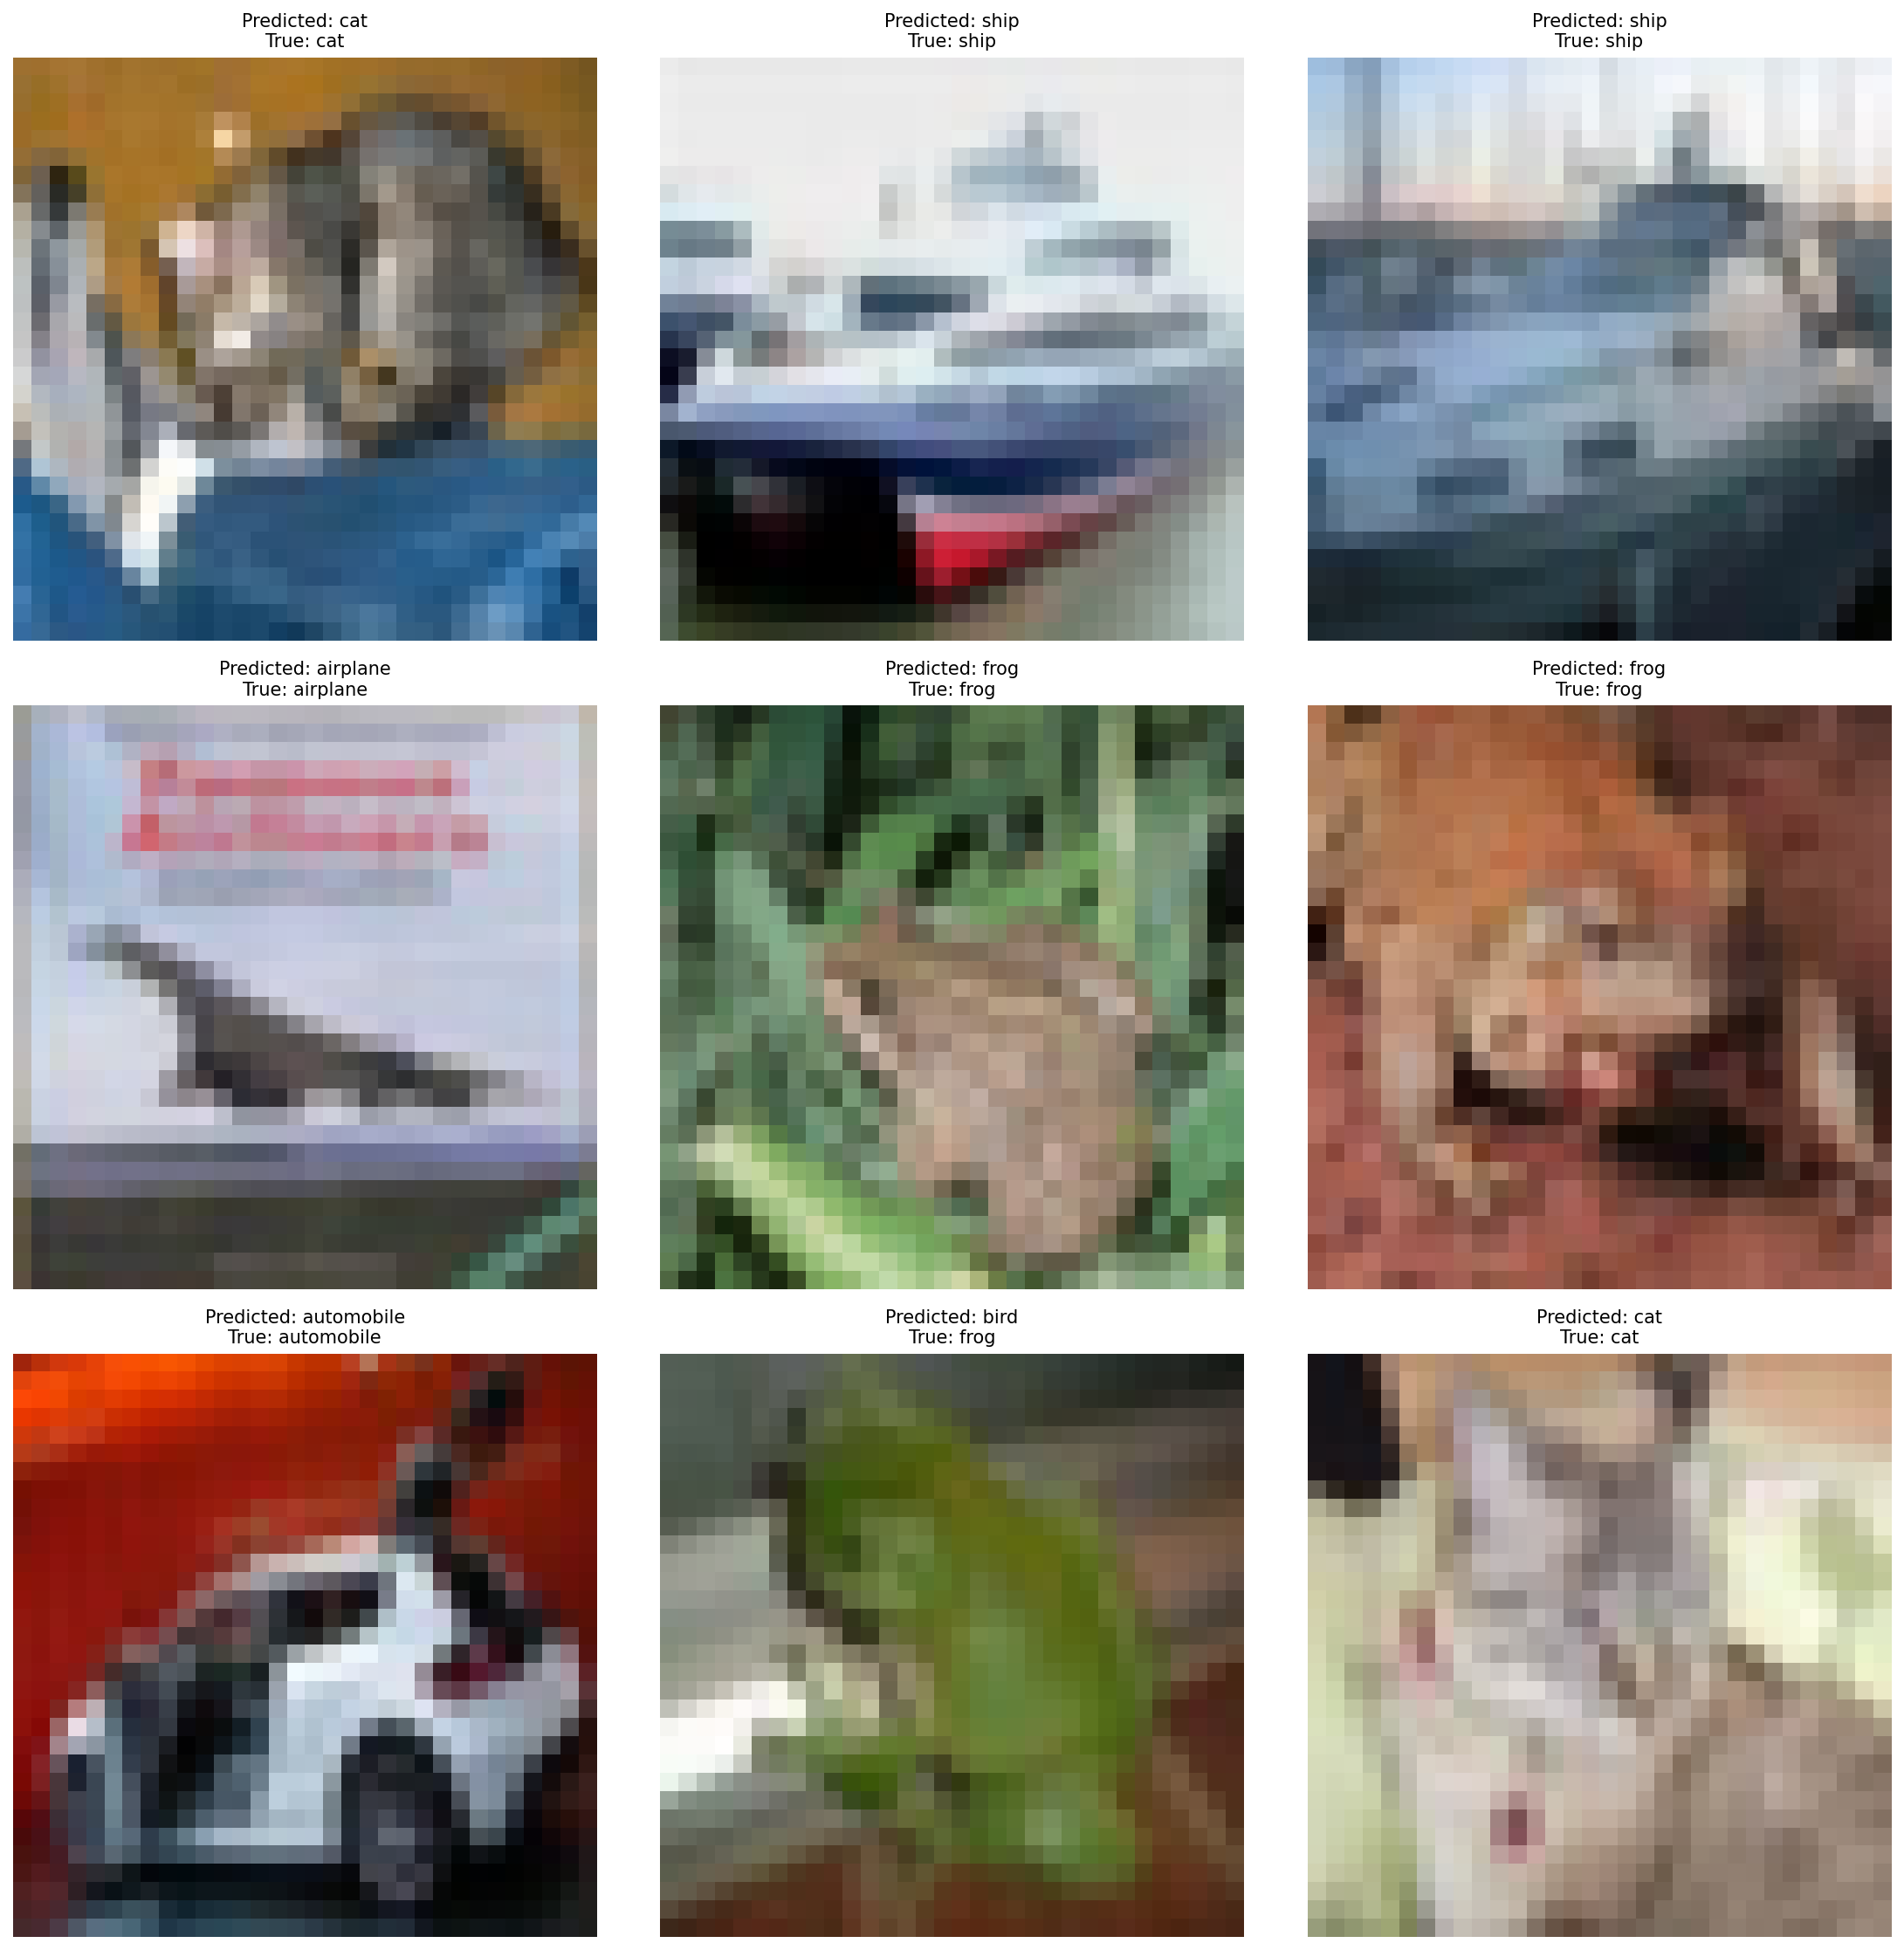

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def predict_sample_images_grid(model, test_loader, device, num_samples=9):
    """Predicts and displays sample images with their labels in a grid (clearer).

    Args:
        model: The trained PyTorch model.
        test_loader: DataLoader for the test dataset.
        device: Device to run the model on (e.g., 'cuda' or 'cpu').
        num_samples: Number of sample images to display (default: 9 for 3x3 grid).
    """

    model.to(device)
    model.eval()

    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Create a 3x3 grid of subplots with larger figsize and higher DPI
    fig, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=150)  # Increased figsize and DPI

    # Display images with predictions and true labels in the grid
    for i in range(num_samples):
        row = i // 3  # Calculate row index
        col = i % 3   # Calculate column index
        ax = axes[row, col]

        # Unnormalize image for display
        image = np.transpose(images[i].cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5

        # Display image with adjusted interpolation (nearest)
        ax.imshow(image, interpolation='nearest')
        ax.set_title(f"Predicted: {train_dataset.classes[predicted[i]]}\nTrue: {train_dataset.classes[labels[i]]}", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with 9 samples for a 3x3 grid
predict_sample_images_grid(model, test_loader, device, num_samples=9)